In [1]:
%matplotlib notebook 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize
import matplotlib.pyplot as plot

from emcee import EnsembleSampler

In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [3]:
npr.seed(1234)

In [4]:
from sklearn.datasets import make_blobs

def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

n_dim = 2
x_tra, y_tra = make_blobs(n_samples=10, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.5)
x_tes, y_tes = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.5)

y_tra = label_map(y_tra, [0, 2], 0)
y_tra = label_map(y_tra, [1, 3], 1)
y_tes = label_map(y_tes, [0, 2], 0)
y_tes = label_map(y_tes, [1, 3], 1)

In [5]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

In [6]:
def logreg(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return sigmoid(y)

In [7]:
def logreg_dist(y, x, w, avg=False):
    y_ = logreg(x, w)
    
    d = -(y * numpy.log(y_ + 1e-12) + (1. - y) * numpy.log(1-y_ + 1e-12))
    
    if not avg:
        return d
    return numpy.mean(d)

In [8]:
def logprior(w):    
    if (w ** 2).sum() < 10.:
        return 0.0
    return -numpy.inf

def logp(w, x, y):
    return -logreg_dist(y, x, w).sum() + logprior(w)

In [9]:
from multiprocess import Pool

In [10]:
def predict(xx, n=5, n_chains=8, interval=1, burnin=100):

    sampler = EnsembleSampler(n_chains, n_dim+1, logp, a=2.0, args=[x_tra, y_tra], threads=2)
    pos, _, _ = sampler.run_mcmc(0.1 * numpy.random.randn(n_chains, n_dim+1), burnin)
    sampler.reset()
    sampler.run_mcmc(pos, n * interval)
    
    ws_ = sampler.chain[:,::interval,:].reshape(-1, n_dim+1)
    ws = [ws_[ii] for ii in xrange(n)]
   
    p = Pool(n_chains)
    tpred = p.map(lambda w_: logreg(xx, w_), ws)
    p.close()

    tpred = numpy.concatenate([tp[:,None] for tp in tpred], 1)
    wpred = numpy.mean(tpred, -1)
    
    return wpred

In [11]:
tra_er = numpy.sum(numpy.abs(numpy.round(predict(x_tra, n=20)) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(numpy.round(predict(x_tes, n=20)) - y_tes)) / numpy.float(len(y_tes))

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 0.0, Test error rate 0.07


In [12]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [13]:
def vis_decision_boundary(typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    pred = predict(numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1), n=20)
    plt1 = plot.contourf(xx, yy, pred.reshape(xx.shape), cmap=plot.cm.coolwarm, alpha=0.4)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

<IPython.core.display.Javascript object>


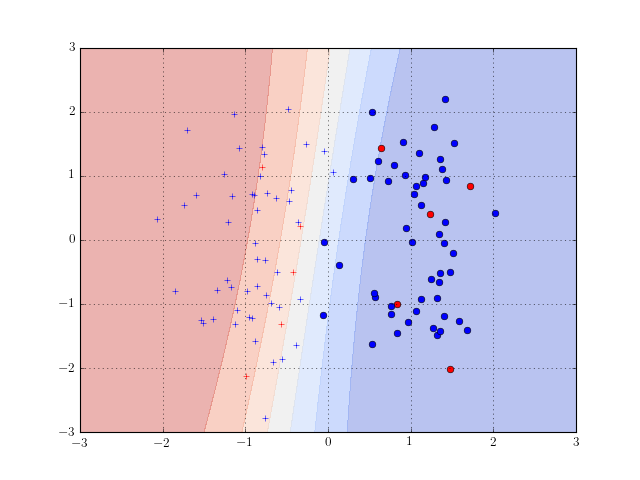

In [14]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
vis_data(x_tes, y_tes, c='b')

plt1 = vis_decision_boundary('k--')

plot.show()

In [15]:
plot.savefig('../figures/bayes_logreg.pdf', dpi=100)